In [35]:
## import dependencies
import pandas as pd

from pypfopt.efficient_frontier import EfficientFrontier
from pypfopt.discrete_allocation import DiscreteAllocation, get_latest_prices
from pypfopt import objective_functions
from pypfopt import risk_models
from pypfopt import expected_returns
from pypfopt import plotting
from time import sleep
import copy
import numpy as np

import matplotlib.pyplot as plt
from pycoingecko import CoinGeckoAPI
cg = CoinGeckoAPI()

## get data from the csv
df = pd.read_csv("test_data.csv", index_col="day")
print(len(df))

334


## USER PREFERENCES
* Risk appetite
* Time frame
* Capital
* Sensibilites

We must find ways to incorporate these preferences into the user's portfolio.

In [36]:
## collect historical price data from coingecko
prices = {
    'dai': [],
    'uniswap': [],
    'frax': [],
    'aave':[],
    'chainlink': [],
    'maker': []
}
def collect_daily_data(month, days):
    i = 1
    while i <= days:
        for key in prices.keys():
            raw_data = cg.get_coin_history_by_id(id=key, date=f'{(i):02d}-{month:02d}-2021')

            prices[key].append(raw_data['market_data']['current_price']['usd'])
            if days > 7:
                sleep(1.25)    #in seconds
        i += 1

# collect_daily_data(6, 30)
# df_coing = pd.DataFrame(prices)
# df_coing.index.rename('day', inplace=True)
# print(df_coing)

In [37]:
## clean df
index_len = len(df.index)
new_index = np.arange(0, index_len, 1)
df.index = new_index
df.index.rename('Day', inplace=True)

## produce an efficient frontier
mu = expected_returns.mean_historical_return(df, compounding=True)
S = risk_models.risk_matrix(df, method='exp_cov')
# S = risk_models.fix_nonpositive_semidefinite(S)

ef = EfficientFrontier(mu, S)


In [38]:
## function that plots cumulative returns of the protocols
def cumul_returns(datafrm):
    datafrm.pct_change().add(1).cumprod().sub(1).plot(legend=True,
        title='Cumulative Returns by Day', ylabel='Percent returns', colormap='Set2')
    plt.tight_layout()
    plt.show()

def price_graph(datafrm):
    datafrm.pct_change().plot(legend=True,
        title='Return by Day', ylabel='Percent returns', colormap='Set2', logy=False)
    plt.tight_layout()
    plt.show()

In [39]:
## function that plots effiecient frontier and randomly generated portfolios
def plot_random_portfolios(e):
    fig, ax = plt.subplots()
    ef_max_sharpe = copy.deepcopy(e)
    my_range = np.linspace(-0.1, 1.5, 100)
    plotting.plot_efficient_frontier(e, ax=ax, show_assets=False)

    # Find the tangency portfolio
    ef_max_sharpe.max_sharpe()
    ret_tangent, std_tangent, _ = ef_max_sharpe.portfolio_performance(verbose=True)
    print(ef_max_sharpe.weights)
    ax.scatter(std_tangent, ret_tangent, marker="*", s=100, c="r", label="Max Sharpe")

    # Generate random portfolios
    n_samples = 10000
    w = np.random.dirichlet(np.ones(e.n_assets), n_samples)
    rets = w.dot(ef.expected_returns)
    stds = np.sqrt(np.diag(w @ e.cov_matrix @ w.T))
    sharpes = rets / stds
    ax.scatter(stds, rets, marker=".", c=sharpes, cmap="viridis_r")

    # Output
    ax.set_title("Efficient Frontier with random portfolios")
    ax.legend()
    plt.tight_layout()
    plt.show()

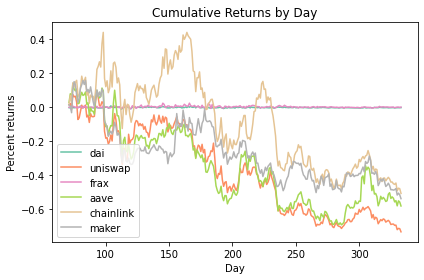

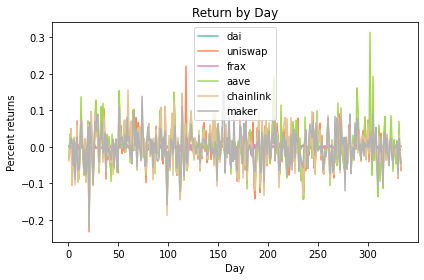

<AxesSubplot:xlabel='Day'>

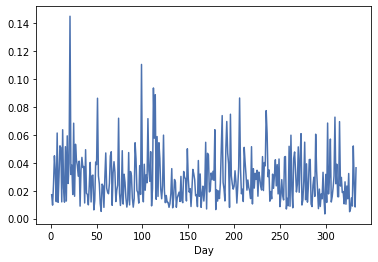

In [44]:
# price_graph(df)
cumul_returns(df.iloc[70:])
# print(len(df))

growth_df = df.iloc[0:45]
price_graph(df)

df.pct_change().abs().mean(axis=1).plot()
# cumul_returns(growth_df)

In [41]:
mu = expected_returns.mean_historical_return(growth_df, compounding=True)
S = risk_models.risk_matrix(growth_df, method='exp_cov')
S = risk_models.fix_nonpositive_semidefinite(S)

growth_ef = EfficientFrontier(mu, S)
# plot_random_portfolios(growth_ef)

In [42]:
## maximise returns
def plot_max_returns(e, risk):
    fig, ax = plt.subplots()
    ef_max_ret = copy.deepcopy(e)

    plotting.plot_efficient_frontier(e, ax=ax, show_assets=False)

    # Find the tangency portfolio
    ef_max_ret.efficient_risk(risk)
    ret_tangent, std_tangent, _ = ef_max_ret.portfolio_performance(verbose=True)
    print(ef_max_ret.weights)
    ax.scatter(std_tangent, ret_tangent, marker="*", s=100, c="r", label="Optimal")

    # Generate random portfolios
    n_samples = 10000
    w = np.random.dirichlet(np.ones(e.n_assets), n_samples)
    rets = w.dot(ef.expected_returns)
    stds = np.sqrt(np.diag(w @ e.cov_matrix @ w.T))
    sharpes = rets / stds
    ax.scatter(stds, rets, marker=".", c=sharpes, cmap="viridis_r")

    # Output
    ax.set_title("Efficient Frontier with random portfolios")
    ax.legend()
    plt.tight_layout()
    plt.show()

/home/gloria/.local/lib/python3.8/site-packages/pypfopt/plotting.py:190: UserWarning: Could not construct portfolio for parameter value -0.001
  warnings.warn(


ValueError: Weights is None

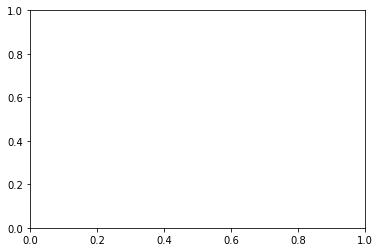

In [43]:
plot_max_returns(ef, 0.25)